In [22]:
import pandas as pd
import numpy as np
import torch as th
from tqdm import tqdm

In [2]:
from torchvision.datasets import MNIST

In [3]:
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
device = th.device('cuda')

In [36]:
th.cuda.is_available()

True

In [5]:
data = MNIST('/data',download=True,transform=transform.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

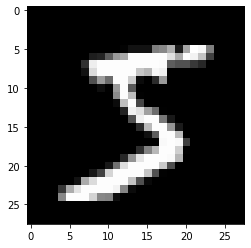

In [7]:
img,label = data[0]
plt.imshow(img.reshape(28,28),cmap='gray')

In [8]:
img.shape

torch.Size([1, 28, 28])

In [9]:
val_size = 10000

In [10]:
train_size= len(data)-val_size

In [11]:
train_ds,val_ds = random_split(data,[train_size,val_size])

In [12]:
img,lab = train_ds[0]

In [13]:
bs=128

In [15]:
train_loder = DataLoader(train_ds,batch_size=bs,shuffle=True)
val_loder = DataLoader(val_ds,batch_size=bs,shuffle=True)

In [16]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [17]:
device

device(type='cuda')

In [20]:
for xb, yb in val_loder:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([8, 5, 9, 0, 6, 5, 9, 7, 6, 4, 6, 6, 8, 9, 5, 0, 8, 2, 8, 0, 8, 0, 6, 3,
        8, 2, 2, 5, 0, 8, 4, 7, 0, 1, 1, 3, 2, 5, 4, 8, 1, 6, 5, 5, 0, 6, 4, 4,
        9, 8, 4, 2, 2, 3, 3, 7, 4, 6, 3, 7, 0, 6, 8, 3, 6, 3, 8, 7, 6, 2, 3, 8,
        3, 5, 1, 1, 9, 7, 6, 8, 1, 9, 1, 0, 4, 6, 9, 7, 9, 1, 0, 1, 3, 2, 5, 4,
        1, 7, 0, 1, 8, 9, 9, 7, 2, 3, 7, 2, 2, 8, 2, 4, 7, 7, 2, 0, 4, 6, 5, 6,
        3, 3, 5, 5, 9, 2, 6, 5])


In [23]:
class NeuralNet(nn.Module):
  def __init__(self,layers_size):
    # layers_size = [720,100,10]
    super().__init__()
    self.layers = []
    self.val_loss = []
    self.loss = []
    
    for i in range(len(layers_size)-1):
      self.layers.append(nn.Linear(layers_size[i],layers_size[i+1]))
    
  def forward(self,input):
    # [lay1,lay2,out]
    #print('Yee')
    out = input.view(input.size(0),-1)
    for i in range(len(self.layers)-2):
      out = F.relu(self.layers[i](out))
    output = th.sigmoid(self.layers[-1](out))
    return output

  def training_step(self,batch):
    images ,labels = batch
    #print('From th')
    pred = self(images)
    #print('From End')
    loss = F.cross_entropy(pred,labels)
    return loss

  def validation_step(self,batch):
    images,lables = batch
    pred = self(images)
    loss = F.cross_entropy(pred,lables)
    acc = self.accuracy(pred,lables)
    return (loss,acc)
  
  def accuracy(self,outputs, labels):
    _, preds = th.max(outputs, dim=1)
    return th.tensor(th.sum(preds == labels).item() / len(preds))


  def val_train_end(self,vallod):
    Acc = 0
    Loss = 0
    for batch in vallod:
      loss,acc = self.validation_step(batch)
      Acc = Acc + acc
      Loss = Loss + loss
      self.val_loss.append(float(loss))
    return {'valloss':float(Loss/len(vallod)),'Acc':float(Acc/len(vallod))}
  
  def predict(self,img):
    return self(img)

  def eval(self,epoch,batch):
    epoch = epoch*batch
    #print('>>> : ',len(self.loss),len(self.val_loss))
    l = len(self.loss)
    l2 = len(self.val_loss)
    plt.plot(np.linspace(0,l,l),self.loss,color='blue',label='train loss')
    plt.plot(np.linspace(0,l2,l2),self.val_loss,color='red',label='Vali loss')
    
  def fit(self,trainlod,vallod,epoch,lr_rate=0.01):

    opt = th.optim.SGD(self.layers[-1].parameters(),lr=lr_rate)

    for i in tqdm(range(epoch)):
      l = 0
      for batch in trainlod:
       # print('=========>>>> ',len(batch))
        loss = self.training_step(batch)
        l = l + loss
        loss.backward()
        opt.step()
        opt.zero_grad()
        self.loss.append(float(loss))
      d = self.val_train_end(vallod)
      print('Loss  ',float(l/len((trainlod))),d)



In [33]:
mod = NeuralNet([28*28,10]).to('cuda')

In [32]:
mod.fit(train_loder,val_loder,5,lr_rate=0.1)

 20%|██        | 1/5 [00:07<00:29,  7.43s/it]

Loss   1.8963185548782349 {'valloss': 1.7678050994873047, 'Acc': 0.8280261158943176}


 40%|████      | 2/5 [00:14<00:22,  7.42s/it]

Loss   1.733341097831726 {'valloss': 1.7086455821990967, 'Acc': 0.8444422483444214}


 60%|██████    | 3/5 [00:22<00:14,  7.42s/it]

Loss   1.69450044631958 {'valloss': 1.6827532052993774, 'Acc': 0.8519580960273743}


 80%|████████  | 4/5 [00:29<00:07,  7.42s/it]

Loss   1.6737817525863647 {'valloss': 1.6668757200241089, 'Acc': 0.8576938509941101}


100%|██████████| 5/5 [00:37<00:00,  7.42s/it]

Loss   1.6600817441940308 {'valloss': 1.6554005146026611, 'Acc': 0.862539529800415}


In [34]:
mod.fit(train_loder,val_loder,5,lr_rate=0.1)

 20%|██        | 1/5 [00:07<00:29,  7.40s/it]

Loss   1.8964495658874512 {'valloss': 1.76724112033844, 'Acc': 0.8254548907279968}


 40%|████      | 2/5 [00:14<00:22,  7.40s/it]

Loss   1.7334800958633423 {'valloss': 1.7087547779083252, 'Acc': 0.8481012582778931}


 40%|████      | 2/5 [00:18<00:27,  9.04s/it]


KeyboardInterrupt: ignored

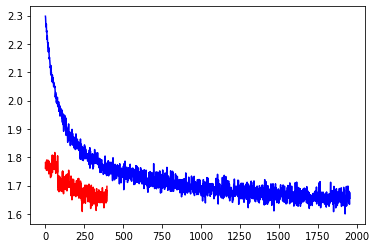

In [26]:
mod.eval(5,bs)

In [30]:
im = val_ds[0]


In [32]:
imm,lab = im

In [34]:
x = mod.predict(imm)

In [58]:
def pred(img,lab):
  pr = mod.predict(img)
  val,prd = th.max(pr,dim=1)
  print('Acc : ',mod.accuracy(pr,lab))
  return val.detach().numpy(),prd.detach().numpy()

In [59]:
test_img = MNIST('/data',train=False,transform=transform.ToTensor())

In [61]:
for i in range(10):
  img,lab = test_img[i]
  p = pred(img,lab)
  print('======> ',lab,p)


Acc :  tensor(1.)
======>  7 (array([0.9981939], dtype=float32), array([7]))
Acc :  tensor(1.)
======>  2 (array([0.9503635], dtype=float32), array([2]))
Acc :  tensor(1.)
======>  1 (array([0.9843667], dtype=float32), array([1]))
Acc :  tensor(1.)
======>  0 (array([0.99304926], dtype=float32), array([0]))
Acc :  tensor(1.)
======>  4 (array([0.93323314], dtype=float32), array([4]))
Acc :  tensor(1.)
======>  1 (array([0.99204856], dtype=float32), array([1]))
Acc :  tensor(1.)
======>  4 (array([0.944971], dtype=float32), array([4]))
Acc :  tensor(1.)
======>  9 (array([0.8996792], dtype=float32), array([9]))
Acc :  tensor(0.)
======>  5 (array([0.34094036], dtype=float32), array([6]))
Acc :  tensor(1.)
======>  9 (array([0.9367736], dtype=float32), array([9]))


In [62]:
th.save(mod.state_dict(),'testmod.pth')